This version is different from first version as I used a non-compact cross validation structure rather than a compact pipeline structure. Pipeline structure lets you get average results but it doesn't allow you to analyze results of each fold independently. With this kind of structure, I will be able to see best hyperparameters for each fold, their performance and variation. 

If hyperparameters vary too much for different folds, it means there is a structural problem to analyze. CrossValidation aims to show the generalized performance of a model, if it varies too much, we have to dig deeper to have a more generalized model. So, it is a nice way to analyze each fold independently. 

In [1]:
#importing libraries that will be required initially. Timeit will let me record the training time and warnings library is for
#filtering some of the warnings will occur at the spyder console during training process.
import pandas as pd
import numpy as np
import warnings
import timeit
# set option is the setting for spyder console, to be able to see all available columns and analysis of them
pd.set_option('display.max_columns',25)
start_time = timeit.default_timer()
warnings.filterwarnings("ignore", category=FutureWarning)
heart = pd.read_csv(r'C:\Users\ali.kilinc\Desktop\Heart Disease Classification\heart.csv', index_col= False)

In [2]:
#Initial analyis of data, columns and statistical summary. 
print(heart.info())
print(heart.describe())
print(heart.columns)
print(heart.head(5))
print(heart.dtypes)
#These columns are known to be categories initially. But code recognized them as int or float. Below code makes the conversion
for col in ['sex','cp','fbs','restecg','exang','slope','thal']:
    heart[col] = heart[col].astype('object')

#There is not any null data in dataset. So we wont need any imputation method.
#If it was needed, Imputation would be inside training pipeline or CV pipeline, in order to eliminate "Data Leakage" problems. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000 

In [3]:
#Dataset is divided into input and output sets
X = heart.iloc[:, :-1]
xcol = heart.columns[:-1]
df_x = pd.DataFrame(X, columns = xcol)

Y = heart.iloc[:, 13:]
ycol = heart.columns[13:]
df_y = pd.DataFrame(Y, columns = ycol)

#columns are investigated for being fixed and empty. If there is any, they will not be included in analysis
#Empty and fixed columns will not contribute to training process, whereas they will decrease the efficiency

num_cols = list(df_x._get_numeric_data().columns)

fix_cols = []
for col in df_x.columns:
    if df_x[col].nunique() == 1:
        fix_cols.append(col)
    else:
        pass

emp_cols = []
for col in df_x.columns:
    if df_x[col].count() > 0:
        pass
    else:
        emp_cols.append(col)

cat_cols = list(set(df_x.columns) - set(num_cols) - set(emp_cols) - set(fix_cols))
num_cols = list(set(num_cols) - set(fix_cols) - set(emp_cols))
print(num_cols)
print(cat_cols)
print(emp_cols)
print(fix_cols)

df_x.drop(list(emp_cols+fix_cols))

['ca', 'age', 'chol', 'thalach', 'oldpeak', 'trestbps']
['fbs', 'exang', 'cp', 'slope', 'thal', 'restecg', 'sex']
[]
[]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2


In [4]:
print(df_x[cat_cols].describe())
print(df_x[num_cols].describe())
print(df_x.info())

        fbs  exang   cp  slope  thal  restecg  sex
count   303    303  303    303   303      303  303
unique    2      2    4      3     4        3    2
top       0      0    0      2     2        1    1
freq    258    204  143    142   166      152  207
               ca         age        chol     thalach     oldpeak    trestbps
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000
mean     0.729373   54.366337  246.264026  149.646865    1.039604  131.623762
std      1.022606    9.082101   51.830751   22.905161    1.161075   17.538143
min      0.000000   29.000000  126.000000   71.000000    0.000000   94.000000
25%      0.000000   47.500000  211.000000  133.500000    0.000000  120.000000
50%      0.000000   55.000000  240.000000  153.000000    0.800000  130.000000
75%      1.000000   61.000000  274.500000  166.000000    1.600000  140.000000
max      4.000000   77.000000  564.000000  202.000000    6.200000  200.000000
<class 'pandas.core.frame.DataFrame'>
Range

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


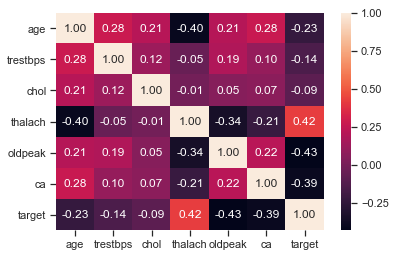

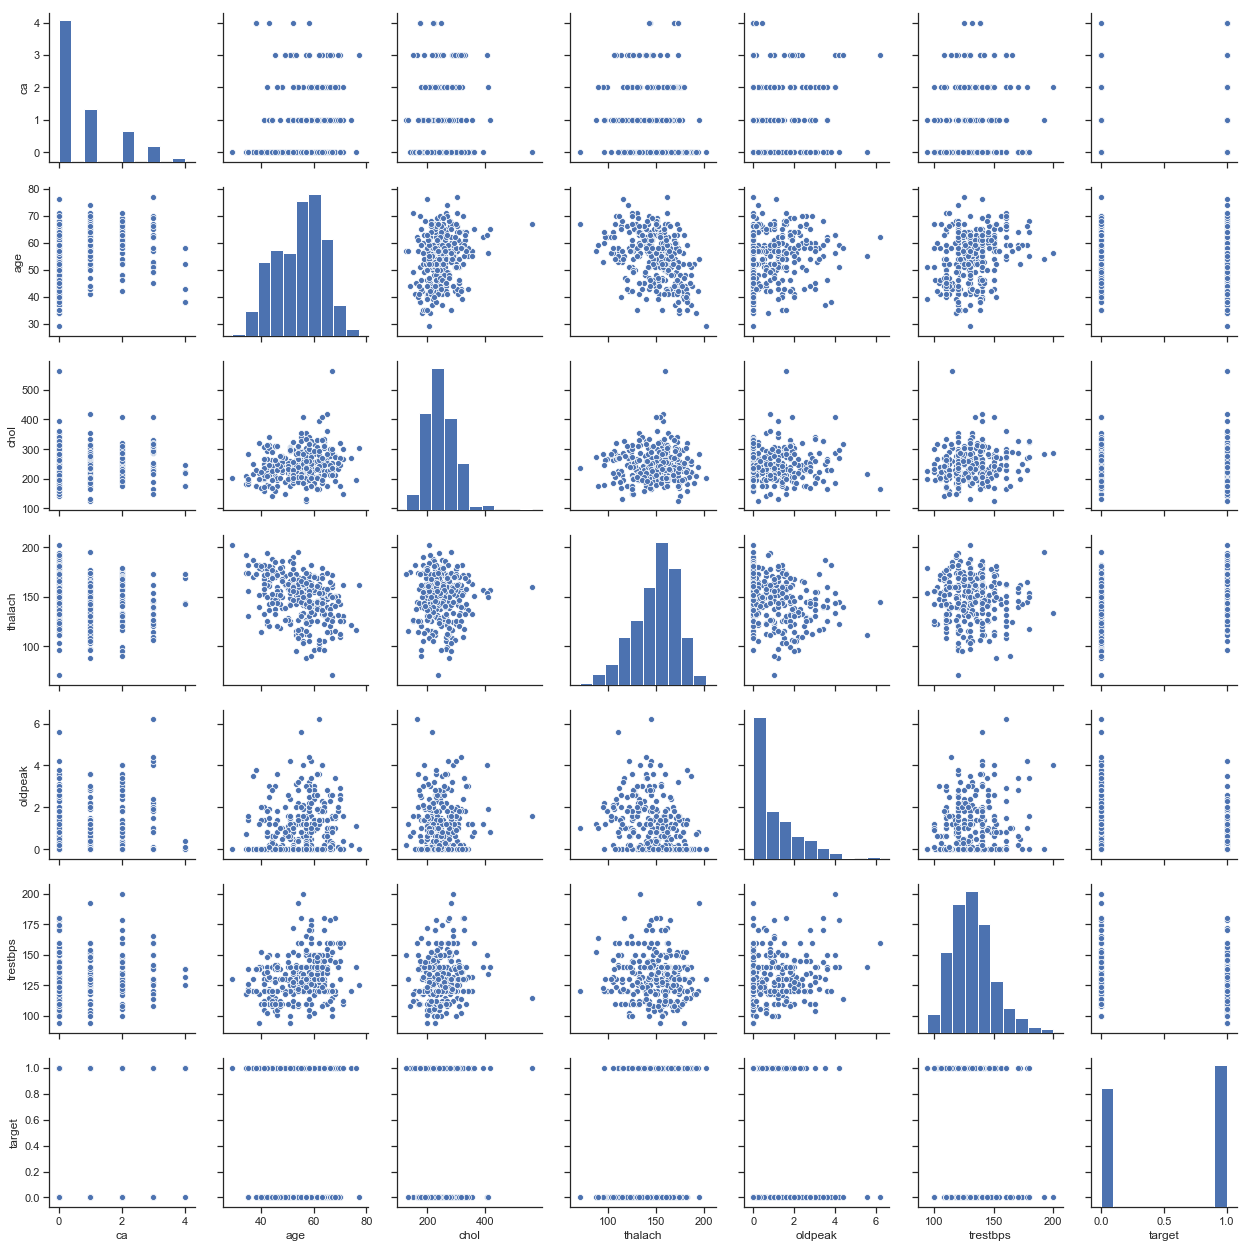

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df_x.columns)
sns.set(style="ticks", color_codes=True)

sns.heatmap(heart.corr(), annot = True, fmt=".2f")
plt.show()

sns.pairplot(heart, vars = num_cols + list(df_y.columns))
plt.show()

#after looking at heatmap of the variables, there is not a clear multicollienarity problem amont numerical features. 
#We won't need to eliminate these from dataset inside training.

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, CategoricalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

Dataset have both categorical and numeric features. So, for preproessing, we have to handle both of these. As i stated before, preprocessing should be completed on training data, not on the whole dataset, in order to eliminate any data leakage.

I have to apply both numerical and categorical preprocessing, in first version of model i used a combination of 2 pipelines but in this construction I couldn't use a pipeline structure. Rather I used an open formation for preprocessing. 

As an initial model i used a RandomForestClassifier, which is a Bagging algorithm consists of several DecisionTree algorithms. It needs categorical data to be converted, so i used OneHotEncoding. Also, numerical data are standardized with a standardScaler.

After getting a satisfactory regularization score from a model, it may be run on whole dataset with a single split, to finalize the model creation process and get a more detailed analysis of the training stage like ClassificationReport etc.

In [8]:
rf = RandomForestClassifier(random_state = 23)
ohe = OneHotEncoder(sparse=True, handle_unknown = 'ignore')
ssc = StandardScaler()
outer_kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=1)
inner_kf = StratifiedKFold(n_splits=3,shuffle=False,random_state=2)

#print(df_x['cp'].unique())
#print(df_x.columns)

params = {
        'max_depth':np.linspace(1, 32, 8, endpoint=True),
        'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
        'min_samples_split': np.linspace(0.1, 1.0, 5, endpoint=True),
        'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True)
        }

outer_loop_accuracy_scores = []
outer_loop_roc_auc_scores = []
inner_loop_won_params = []
inner_loop_accuracy_scores = []

In [11]:
for train_index,test_index in outer_kf.split(df_x,df_y.values.ravel()):
    
    GSCV = GridSearchCV(estimator=rf,param_grid=params,cv=inner_kf, verbose = 0)
    
    df_x_train, df_x_test = df_x.values[train_index], df_x.values[test_index]
    df_y_train, df_y_test = df_y.values.ravel()[train_index], df_y.values.ravel()[test_index]
    
    df_x_train = ssc.fit_transform(df_x_train)
    df_x_test = ssc.transform(df_x_test)
    
    ohe_x = ohe.fit_transform(df_x_train)
    ohe_x_test = ohe.transform(df_x_test)
    #i was not using .values and .values.ravel() at first and i got errors. It was because fit_transform and accuracy_score like functions require inputs to be array
    #My input was a dataframe. So it seek for indexes as columns but couldnt find(1 row array with columns as indexes). I transformed x with .values into array.
    # also .values.ravel() is used for y values. It started to work then. !!!!!!! .values .ravel() importance
    # GSCV is looping through the training data to find the best parameters. This is the inner loop
    GSCV.fit(ohe_x,df_y.values.ravel()[train_index])
    
    # The best hyper parameters from GSCV is now being tested on the unseen outer loop test data.
    pred = GSCV.predict(ohe_x_test)
    
    # Appending the "winning" hyper parameters and their associated accuracy score
    inner_loop_won_params.append(GSCV.best_params_)
    outer_loop_accuracy_scores.append(accuracy_score(df_y.values.ravel()[test_index],pred))
    outer_loop_roc_auc_scores.append(roc_auc_score(df_y.values.ravel()[test_index],pred))
    inner_loop_accuracy_scores.append(GSCV.best_score_)
    

for i in zip(inner_loop_won_params,outer_loop_roc_auc_scores,outer_loop_accuracy_scores,inner_loop_accuracy_scores):
    print(i)

print('Mean of outer loop accuracy score:',np.mean(outer_loop_accuracy_scores))
print('SD of outer loop accuracy score:', np.std(outer_loop_accuracy_scores))
print('Mean of outer loop roc_auc score:',np.mean(outer_loop_roc_auc_scores))
print('SD of outer loop roc_auc score:', np.std(outer_loop_roc_auc_scores))
print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60))

C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Program

({'max_depth': 5.428571428571429, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 32}, 0.8143939393939394, 0.819672131147541, 0.8223140495867769)
({'max_depth': 5.428571428571429, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 100}, 0.7884199134199135, 0.8032786885245902, 0.8181818181818182)
({'max_depth': 5.428571428571429, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 8}, 0.8376623376623378, 0.8360655737704918, 0.8223140495867769)
({'max_depth': 5.428571428571429, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}, 0.8148148148148149, 0.8333333333333334, 0.8395061728395061)
({'max_depth': 5.428571428571429, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 100}, 0.7659932659932659, 0.7833333333333333, 0.831275720164609)
Mean of outer loop accuracy score: 0.8151366120218579
SD of outer loop accuracy score: 0.01970670913729505
Mean of outer loop roc_auc score: 0.8042568542568542
SD of oute

Result looks satisfactory, accuracy and roc scores do not vary with different folds significantly. Also the best parameters can be generalized into full dataset, only n_estimator variable varies a bit but it can be selected as a higher value to cover all of the possibilities and get a high performance for all possible folds and randomization error. 

It is a satisfactory score for a such small dataset.

Furthermore, different models can be trained and compared with this approach. Then, best model will be selected as the main model. 

It is a small dataset and it is not very wise to hold a seperate validation set. But for a larger dataset, a validation set might be used to assess final model performance more accurately with an unseen data.